In [1]:
import jax
from jax import numpy as jnp
import equinox as eqx
from energax.ebms.nn_ebms import ContinuousNNEBM
from energax import nns
from energax.sampling.continuous import LangevinSampler
from energax import losses as elosses
import optax
import matplotlib.pyplot as plt

In [2]:
key = jax.random.PRNGKey(42)

In [3]:
key, subkey1, subkey2 = jax.random.split(key, 3)

data_set_size = 2_000
data = jnp.concatenate(
    (
        -0.5 + 0.2 * jax.random.normal(subkey1, (int(data_set_size * 1 / 5), 2)),
        0.5 + 0.2 * jax.random.normal(subkey2, (int(data_set_size * 4 / 5), 2)),
    ),
    axis=0,
)


print(data.shape)

(2000, 2)


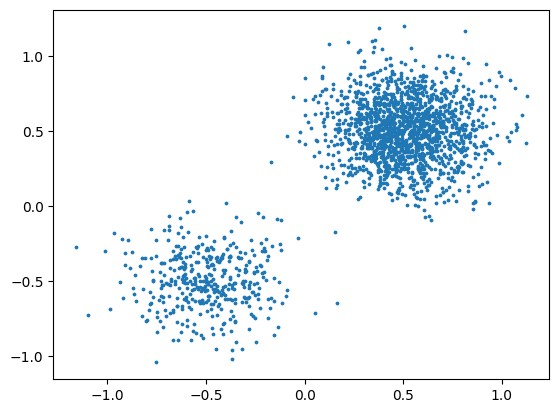

In [4]:
plt.scatter(data[:, 0], data[:, 1], s=3)
plt.show()

In [5]:
key, subkey = jax.random.split(key)
ebm = ContinuousNNEBM(nns.MLP(dims=2, depth=3, width=128, key=subkey))

In [6]:
optimizer = optax.adam(learning_rate=0.001)
opt_state = optimizer.init(eqx.filter(ebm, eqx.is_inexact_array))

epochs = 10_000
batch_size = 128


@eqx.filter_jit
def step(mlp, real_batch, key, opt_state):
    val, grads = loss_grad(mlp, real_batch, key)
    updates, opt_state = optimizer.update(grads, opt_state, mlp)
    mlp = eqx.apply_updates(mlp, updates)
    return mlp, opt_state, val


loss_grad = eqx.filter_value_and_grad(elosses.ssm)
losses = []

for e in range(epochs):
    if e % 500 == 0:
        print(e, "/", epochs)

    key, subkey = jax.random.split(key, 2)
    inds = jax.random.randint(subkey, minval=0, maxval=len(data), shape=(batch_size,))
    key, subkey = jax.random.split(key, 2)
    real_batch = data[inds] + 0.001 * jax.random.normal(subkey, shape=data[inds].shape)

    key, subkey = jax.random.split(key, 2)
    ebm, opt_state, val = step(ebm, real_batch, subkey, opt_state)
    losses.append(val)

0 / 10000
500 / 10000
1000 / 10000
1500 / 10000
2000 / 10000
2500 / 10000
3000 / 10000
3500 / 10000
4000 / 10000
4500 / 10000
5000 / 10000
5500 / 10000
6000 / 10000
6500 / 10000
7000 / 10000
7500 / 10000
8000 / 10000
8500 / 10000
9000 / 10000
9500 / 10000


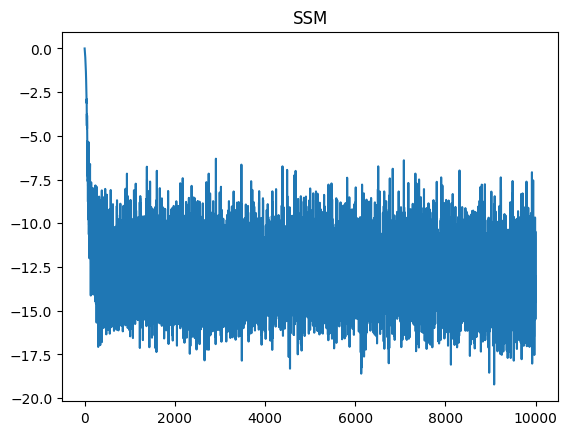

In [7]:
plt.plot(losses)
plt.title("SSM")
plt.show()

In [8]:
sampling_steps = 260
sampling_step_size = 0.001
sigma = 0.01
val = 1.0

inits = jax.vmap(lambda x: jax.random.uniform(x, minval=-val, maxval=val, shape=(2,)))(
    jax.random.split(key, 500)
)
sampler = LangevinSampler(
    (2,), 500, -val, val, sampling_step_size, sigma, sampling_steps, val
)
gen_samples = sampler.sample_chains(ebm, inits, key)["position"]

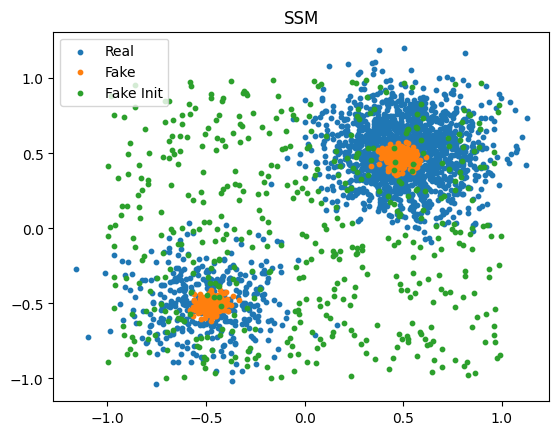

In [12]:
plt.scatter(data[:, 0], data[:, 1], label="Real", s=10)
plt.scatter(gen_samples[:, 0], gen_samples[:, 1], label="Fake", s=10)
plt.scatter(inits[:, 0], inits[:, 1], label="Fake Init", s=10)
plt.title("SSM")
plt.legend()
plt.show()

In [15]:
def get_map(model, density=100, val=1.6):
    xs = jnp.linspace(-val, val, density)
    ys = jnp.linspace(-val, val, density)
    X, Y = jnp.meshgrid(xs, ys)
    XY = jnp.stack([X, Y], axis=-1)
    XY = XY.reshape(-1, 2)
    f_vectorized = jax.vmap(model.energy_function, in_axes=(0))
    Z = f_vectorized(XY)
    Z = Z.reshape(100, 100)
    return X, Y, Z


def get_vectors(model, density=30, val=1.6):
    xs = jnp.linspace(-val, val, density)
    ys = jnp.linspace(-val, val, density)
    X, Y = jnp.meshgrid(xs, ys)
    XY = jnp.stack([X, Y], axis=-1)
    XY = XY.reshape(-1, 2)
    f_vectorized = jax.vmap(jax.grad(lambda x: -1 * model.energy_function(x)), in_axes=(0))
    Z = f_vectorized(XY)
    Z = Z.reshape(density, density, 2)

    return X, Y, Z

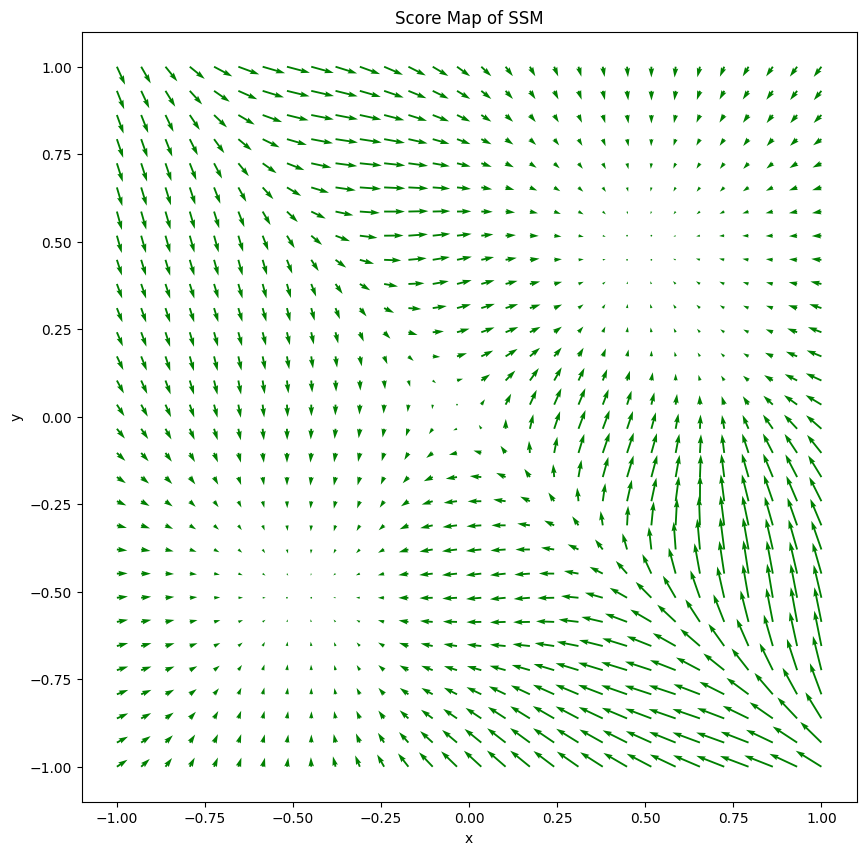

ImportError: dlopen(/Users/ianmaccormack/.local/lib/python3.10/site-packages/contourpy-1.1.0-py3.10-macosx-10.9-x86_64.egg/contourpy/_contourpy.cpython-310-darwin.so, 0x0002): tried: '/Users/ianmaccormack/.local/lib/python3.10/site-packages/contourpy-1.1.0-py3.10-macosx-10.9-x86_64.egg/contourpy/_contourpy.cpython-310-darwin.so' (mach-o file, but is an incompatible architecture (have (x86_64), need (arm64e)))

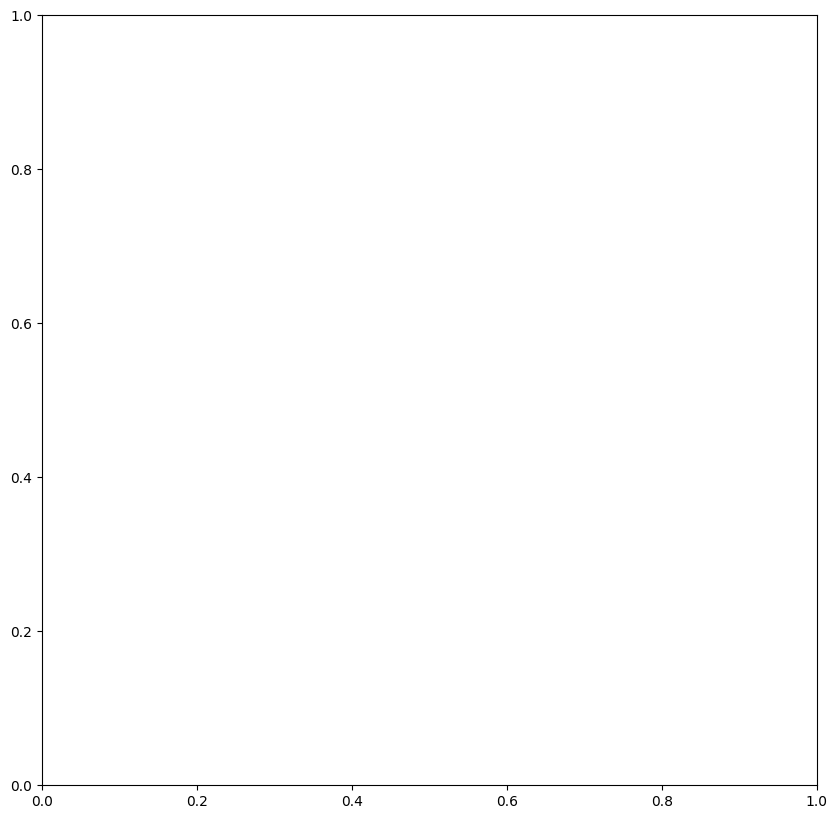

In [16]:
X, Y, Z = get_vectors(ebm, val=val)
plt.figure(figsize=(10, 10))
plt.quiver(X, Y, Z[:, :, 0], Z[:, :, 1], color="g")
plt.title("Score Map of SSM")
plt.xlabel("x")
plt.ylabel("y")
plt.show()


X, Y, Z = get_map(ebm, val=val)
plt.figure(figsize=(10, 10))
plt.contourf(X, Y, Z, 50, cmap="viridis")
plt.colorbar()
plt.title("Heat Contour Map of SSM")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [17]:
inits_s = inits
gen_samples_s = gen_samples

In [18]:
key, subkey = jax.random.split(key, 2)
ebm = ContinuousNNEBM(nns.MLP(dims=2, depth=3, width=10, key=subkey))

In [19]:
optimizer = optax.adam(learning_rate=0.1)
opt_state = optimizer.init(eqx.filter(ebm, eqx.is_inexact_array))

epochs = 200
batch_size = 64


@jax.jit
def step(mlp, real_batch, key, opt_state):
    val, grads = loss_grad(mlp, real_batch, key)
    updates, opt_state = optimizer.update(grads, opt_state, mlp)
    mlp = eqx.apply_updates(mlp, updates)
    return mlp, opt_state, val


loss_grad = eqx.filter_value_and_grad(elosses.dsm)
losses = []

for e in range(epochs):
    if e % 20 == 0:
        print(e, "/", epochs)

    key, subkey = jax.random.split(key, 2)
    inds = jax.random.randint(subkey, minval=0, maxval=len(data), shape=(batch_size,))
    key, subkey = jax.random.split(key, 2)
    real_batch = data[inds] + 0.001 * jax.random.normal(subkey, shape=data[inds].shape)

    key, subkey = jax.random.split(key, 2)
    ebm, opt_state, val = step(ebm, real_batch, subkey, opt_state)
    losses.append(val)

0 / 200
20 / 200
40 / 200
60 / 200
80 / 200
100 / 200
120 / 200
140 / 200
160 / 200
180 / 200


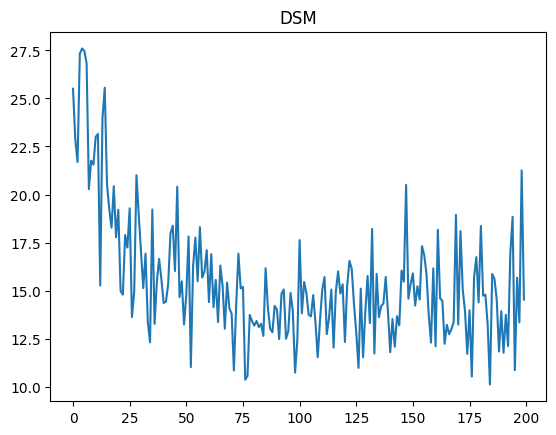

In [20]:
plt.plot(losses)
plt.title("DSM")
plt.show()

In [21]:
sampling_steps = 200
sampling_step_size = 0.01
sigma = 0.01
val = 1.0

inits = jax.vmap(lambda x: jax.random.uniform(x, minval=-1, maxval=1, shape=(2,)))(
    jax.random.split(key, 500)
)
sampler = LangevinSampler(
    (2,), 500, -val, val, sampling_step_size, sigma, sampling_steps, val
)
gen_samples = sampler.sample_chains(ebm, inits, key)["position"]

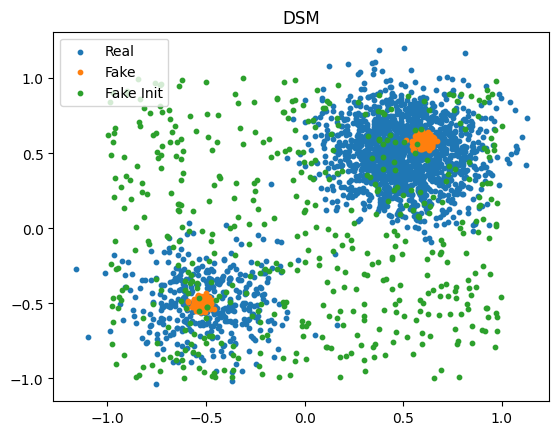

In [23]:
plt.scatter(data[:, 0], data[:, 1], label="Real", s=10)
plt.scatter(gen_samples[:, 0], gen_samples[:, 1], label="Fake", s=10)
plt.scatter(inits[:, 0], inits[:, 1], label="Fake Init", s=10)
plt.title("DSM")
plt.legend()
plt.show()

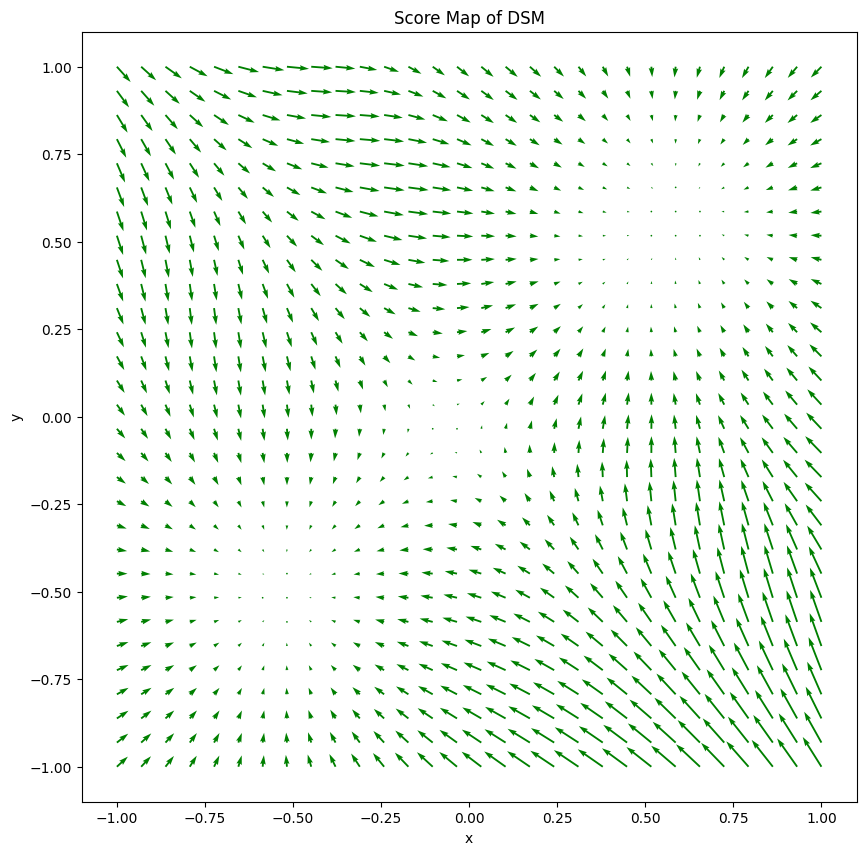

ImportError: dlopen(/Users/ianmaccormack/.local/lib/python3.10/site-packages/contourpy-1.1.0-py3.10-macosx-10.9-x86_64.egg/contourpy/_contourpy.cpython-310-darwin.so, 0x0002): tried: '/Users/ianmaccormack/.local/lib/python3.10/site-packages/contourpy-1.1.0-py3.10-macosx-10.9-x86_64.egg/contourpy/_contourpy.cpython-310-darwin.so' (mach-o file, but is an incompatible architecture (have (x86_64), need (arm64e)))

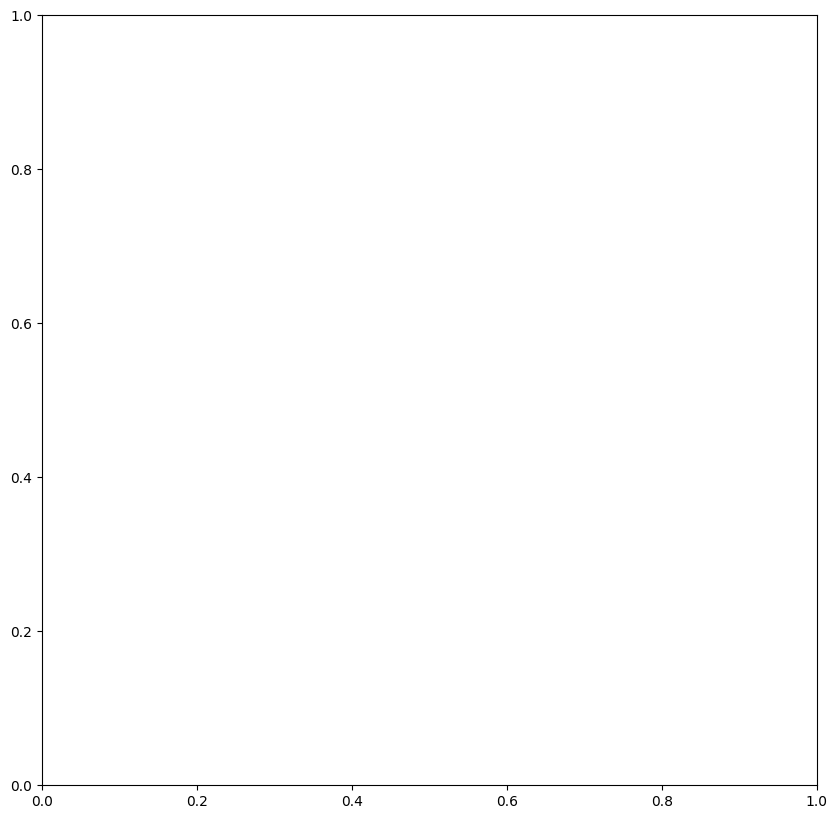

In [24]:
X, Y, Z = get_vectors(ebm, val=val)
plt.figure(figsize=(10, 10))
plt.quiver(X, Y, Z[:, :, 0], Z[:, :, 1], color="g")
plt.title("Score Map of DSM")
plt.xlabel("x")
plt.ylabel("y")
plt.show()


X, Y, Z = get_map(ebm, val=val)
plt.figure(figsize=(10, 10))
plt.contourf(X, Y, Z, 50, cmap="viridis")
plt.colorbar()
plt.title("Heat Contour Map of DSM")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

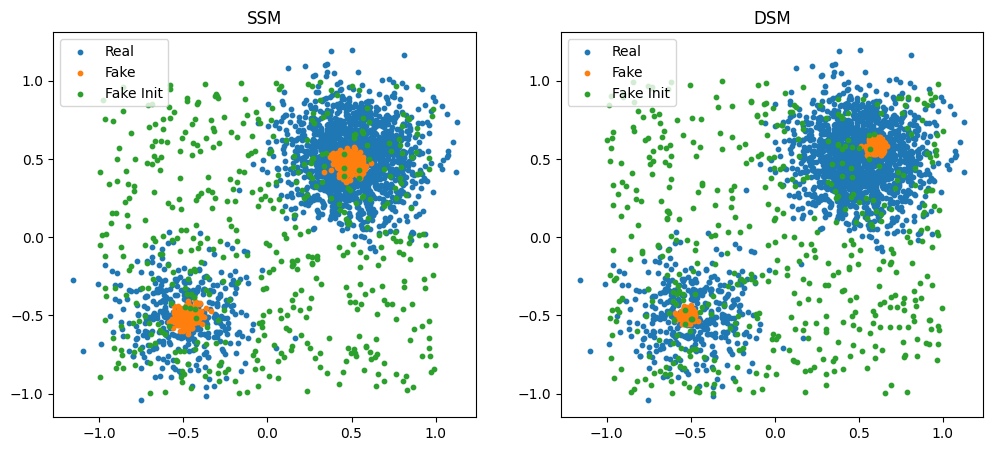

In [25]:
fig, axs = plt.subplots(
    1, 2, figsize=(12, 5)
)  # Create a subplot with 1 row and 2 columns

# Left plot
axs[0].scatter(data[:, 0], data[:, 1], label="Real", s=10)
axs[0].scatter(gen_samples_s[:, 0], gen_samples_s[:, 1], label="Fake", s=10)
axs[0].scatter(inits_s[:, 0], inits_s[:, 1], label="Fake Init", s=10)
axs[0].set_title("SSM")
axs[0].legend()


axs[1].scatter(data[:, 0], data[:, 1], label="Real", s=10)
axs[1].scatter(gen_samples[:, 0], gen_samples[:, 1], label="Fake", s=10)
axs[1].scatter(inits[:, 0], inits[:, 1], label="Fake Init", s=10)
axs[1].set_title("DSM")
axs[1].legend()
plt.show()